In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [179]:
company='SNPS'
df=web.DataReader(company,data_source='yahoo',start='2012,01,01',end='2020,01,01')

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,27.700001,26.969999,27.530001,26.990000,961600,26.990000
2012-01-04,26.920000,26.440001,26.910000,26.490000,885600,26.490000
2012-01-05,26.940001,26.330000,26.480000,26.850000,770900,26.850000
2012-01-06,27.100000,26.610001,26.870001,26.870001,631000,26.870001
2012-01-09,27.219999,26.680000,26.860001,27.040001,638500,27.040001
...,...,...,...,...,...,...
2019-12-24,140.259995,137.500000,139.690002,138.210007,417800,138.210007
2019-12-26,140.300003,138.610001,138.880005,140.070007,539400,140.070007
2019-12-27,140.789993,139.229996,140.419998,140.619995,533400,140.619995


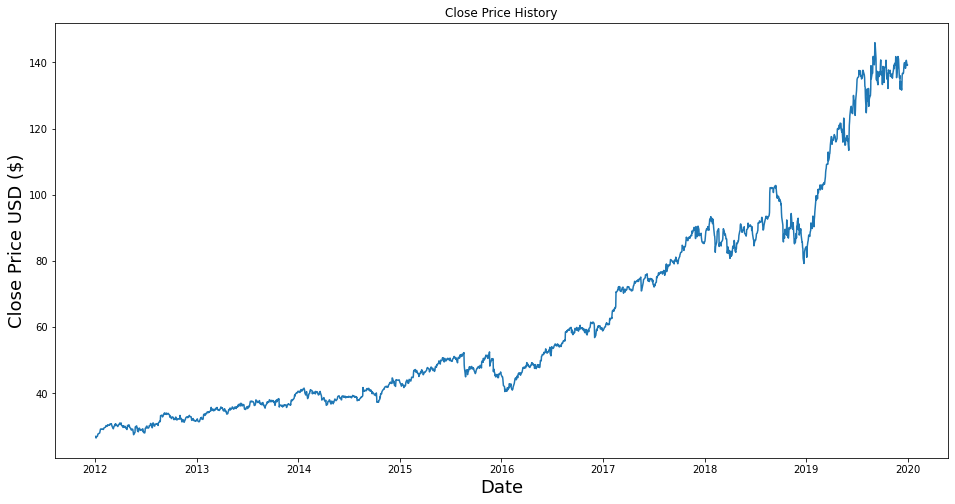

In [180]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()


In [181]:
#scale data

scalar=MinMaxScaler(feature_range=(0,1))
scaled_data=scalar.fit_transform(df['Close'].values.reshape(-1,1))
scaled_data


array([[0.0041855 ],
       [0.        ],
       [0.00301357],
       ...,
       [0.95538254],
       [0.94265871],
       [0.94349573]])

In [182]:
prediction_days=60
x_train=[]
y_train=[]
for x in range(prediction_days,len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train

array([[[0.0041855 ],
        [0.        ],
        [0.00301357],
        ...,
        [0.03406998],
        [0.03415369],
        [0.0358279 ]],

       [[0.        ],
        [0.00301357],
        [0.00318099],
        ...,
        [0.03415369],
        [0.0358279 ],
        [0.03792065]],

       [[0.00301357],
        [0.00318099],
        [0.00460406],
        ...,
        [0.0358279 ],
        [0.03792065],
        [0.03490708]],

       ...,

       [[0.89419053],
        [0.91695967],
        [0.93997992],
        ...,
        [0.9494392 ],
        [0.93520852],
        [0.95077859]],

       [[0.91695967],
        [0.93997992],
        [0.93252974],
        ...,
        [0.93520852],
        [0.95077859],
        [0.95538254]],

       [[0.93997992],
        [0.93252974],
        [0.8994643 ],
        ...,
        [0.95077859],
        [0.95538254],
        [0.94265871]]])

In [6]:
#Build model
model=Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))#prediction of the next closing value

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
61/61 [==============================] - 7s 59ms/step - loss: 0.0378
Epoch 2/50
61/61 [==============================] - 4s 60ms/step - loss: 0.0020
Epoch 3/50
61/61 [==============================] - 4s 60ms/step - loss: 0.0019
Epoch 4/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0017
Epoch 5/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0018
Epoch 6/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0017
Epoch 7/50
61/61 [==============================] - 4s 62ms/step - loss: 0.0017
Epoch 8/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0014
Epoch 9/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0015
Epoch 10/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0013
Epoch 11/50
61/61 [==============================] - 4s 62ms/step - loss: 0.0014
Epoch 12/50
61/61 [==============================] - 4s 61ms/step - loss: 0.0014
Epoch 13/50
61/61 [==================

In [183]:
#Test the model accuracy on existing data
test_start=dt.datetime(2020,1,1)
test_end=dt.datetime.now()

test_data=web.DataReader(company,data_source='yahoo',start=test_start,end=test_end)
actual_prices=test_data['Close'].values
total_dataset=pd.concat((df['Close'],test_data['Close']),axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs=model_inputs.reshape(-1,1)
model_inputs=scalar.transform(model_inputs)


In [184]:
#Make prediction on Test Data
x_test=[]

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])


x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices=model.predict(x_test)
predicted_prices=scalar.inverse_transform(predicted_prices)
print(predicted_prices)

[[136.45107 ]
 [136.52528 ]
 [136.84013 ]
 [137.28722 ]
 [137.8569  ]
 [138.77652 ]
 [140.21756 ]
 [141.87407 ]
 [143.58241 ]
 [144.86726 ]
 [145.5509  ]
 [145.89226 ]
 [146.26538 ]
 [146.90775 ]
 [147.69846 ]
 [148.64845 ]
 [149.47934 ]
 [149.61868 ]
 [149.32353 ]
 [148.62207 ]
 [147.7807  ]
 [146.6185  ]
 [145.65749 ]
 [145.72377 ]
 [146.52336 ]
 [147.7522  ]
 [148.99591 ]
 [150.31656 ]
 [151.69731 ]
 [153.1063  ]
 [154.57677 ]
 [156.15266 ]
 [157.55423 ]
 [158.84386 ]
 [158.6699  ]
 [156.52765 ]
 [152.77977 ]
 [148.02614 ]
 [143.26733 ]
 [138.72165 ]
 [135.03981 ]
 [132.95674 ]
 [132.28363 ]
 [133.42332 ]
 [135.35605 ]
 [136.81517 ]
 [136.32646 ]
 [135.02779 ]
 [133.1919  ]
 [129.92067 ]
 [126.94086 ]
 [123.10632 ]
 [119.53882 ]
 [116.25575 ]
 [113.61698 ]
 [111.311966]
 [109.26074 ]
 [108.801575]
 [109.98976 ]
 [112.98027 ]
 [116.5968  ]
 [120.47468 ]
 [123.93199 ]
 [126.19825 ]
 [127.46077 ]
 [127.45595 ]
 [127.7369  ]
 [128.52003 ]
 [130.00447 ]
 [131.59113 ]
 [133.30734 ]
 [135.

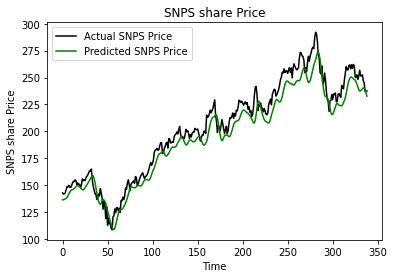

In [185]:
plt.plot(actual_prices,color='black',label=f'Actual {company} Price')
#plt.plot(total_dataset.values,color='black',label=f'Actual {company} Price')
plt.plot(predicted_prices,color='green',label=f'Predicted {company} Price')
plt.title(f'{company} share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} share Price')
plt.legend()
plt.show()

In [186]:
real_data=[model_inputs[len(model_inputs) - prediction_days + 1:len(model_inputs+1),0]]
real_data=np.array(real_data)
real_data=np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction=model.predict(real_data)
prediction=scalar.inverse_transform(prediction)

print(prediction)

[[229.34505]]


In [187]:
R=(prediction-predicted_prices[len(predicted_prices)-1])/(predicted_prices[len(predicted_prices)-1])
print(predicted_prices[len(predicted_prices)-1])
R=100*R
if -1.5<R<1.5:
  print(1)
elif R>1.5:
  print(0)
else:
  print(2)
print(R)

[232.67616]
1
[[-1.4316531]]
